# Нейронная сеть прямого распространения — регрессор
Для регрессии полносвязная сеть строит приближение функции $\hat{y}=f(x)$ через последовательность слоев $h^{(l)} = \sigma(W^{(l)} h^{(l-1)} + b^{(l)})$. Потери обычно задаются как MSE: $\mathcal{L} = \frac{1}{n} \sum_{i=1}^{n} (y_i-\hat{y}_i)^2$. Обучение выполняется методом градиентного спуска с обратным распространением ошибки.


## Используемые библиотеки
Используем `numpy`, `pandas`, `seaborn`, `matplotlib`. Из `sklearn` — `load_diabetes`, `train_test_split`, `StandardScaler`, `Pipeline`, `MLPRegressor`, регрессионные метрики.


In [10]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [11]:
sns.set_theme(style="whitegrid", palette="deep")
plt.rcParams["figure.dpi"] = 120
PRIMARY_COLOR = "#1f77b4"
SECONDARY_COLOR = "#ff7f0e"
HEATMAP_CMAP = "coolwarm"


## Датасет: описание и частичная распечатка
Датасет **Diabetes** — 442 пациента, 10 нормализованных признаков. Задача — регрессия: предсказать количественную меру прогрессирования болезни. Нейросеть особенно полезна, когда зависимость нелинейна: нейроны с ReLU создают кусочно-линейную аппроксимацию произвольной сложности, которая может фиксировать взаимодействия признаков.


In [12]:
diabetes = load_diabetes(as_frame=True)
data = diabetes.frame
print(f"Размерность: {data.shape}")
data.head()


Размерность: (442, 11)


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


## Предварительная обработка
Разделяем признаки и целевую переменную, train/test split (80/20). `StandardScaler` внутри `Pipeline` масштабирует как входные признаки (важно для сходимости SGD), так и не масштабирует целевую переменную — `MLPRegressor` справляется с необработанным `y`.


In [13]:
features = data.drop(columns=["target"])
target = data["target"]

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42
)


## Тепловая карта корреляций
Матрица корреляций для 10 признаков и целевой переменной. **bmi** и **s5** имеют наибольшую линейную связь с прогрессированием диабета. Нейросеть способна уловить как линейные, так и нелинейные взаимодействия — это её главное преимущество перед линейной регрессией и деревом решений на этих данных.


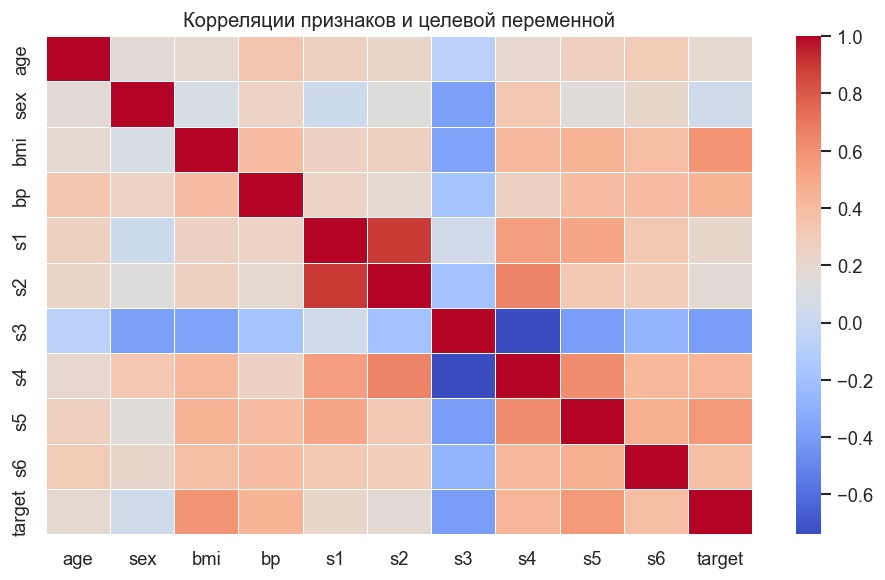

In [14]:
plt.figure(figsize=(8, 5))
correlation = data.corr()
sns.heatmap(correlation, annot=False, cmap=HEATMAP_CMAP, linewidths=0.5)
plt.title("Корреляции признаков и целевой переменной")
plt.tight_layout()
plt.show()


## Обучение модели
`MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', max_iter=800)`. Два скрытых слоя с ReLU. `max_iter=800` — увеличено по сравнению с классификатором, так как регрессионные задачи сходятся медленнее. Оптимизатор Adam (по умолчанию) адаптивно масштабирует learning rate для каждого параметра.


In [15]:
model = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("mlp", MLPRegressor(
            hidden_layer_sizes=(64, 32),
            activation="relu",
            max_iter=800,
            random_state=42,
        )),
    ]
)
model.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()),
                ('mlp',
                 MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=800,
                              random_state=42))])

## Прогнозы модели
Три метрики регрессии:
- **MAE** — среднее абсолютное отклонение в единицах целевой переменной;
- **RMSE** — штрафует крупные ошибки сильнее MAE; сравнима с дисперсией целевой переменной;
- **R²** — ожидаем 0.5–0.6, что лучше линейной регрессии и значительно лучше дерева решений на этом датасете при правильной настройке.


In [16]:
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("MLP Regressor Metrics")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2:   {r2:.3f}")


MLP Regressor Metrics
MAE:  41.76
RMSE: 51.98
R2:   0.490


## Графики выходных результатов
**График 1. Факт vs Прогноз.** В отличие от дерева, нейросеть предсказывает непрерывные значения — точки распределены без ступенчатого эффекта. Хорошая модель — плотное облако вдоль диагонали. Выбросы указывают на аномальные пациенты.

**График 2. Кривая обучения.** MSE по эпохам должна монотонно убывать. Если кривая слишком «рваная» — learning rate велик; если сходится медленно — мало слоев/нейронов или нужен другой оптимизатор.


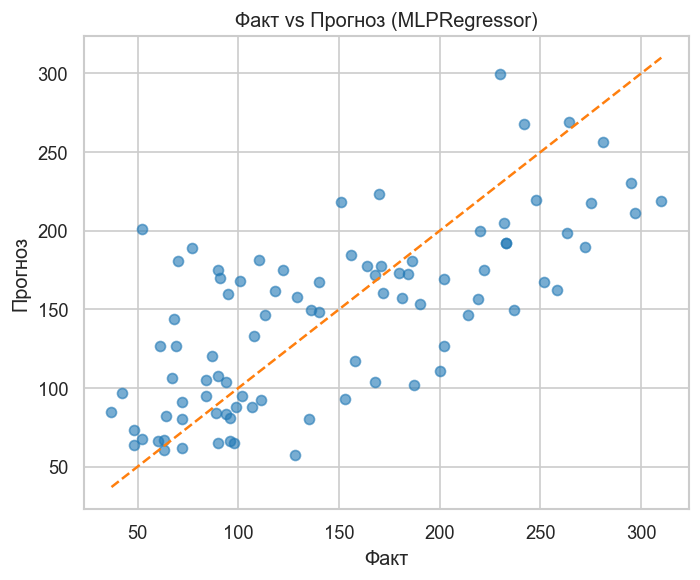

In [17]:
plt.figure(figsize=(6, 5))
plt.scatter(y_test, y_pred, alpha=0.6, color=PRIMARY_COLOR)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    color=SECONDARY_COLOR,
    linestyle="--",
)
plt.xlabel("Факт")
plt.ylabel("Прогноз")
plt.title("Факт vs Прогноз (MLPRegressor)")
plt.tight_layout()
plt.show()


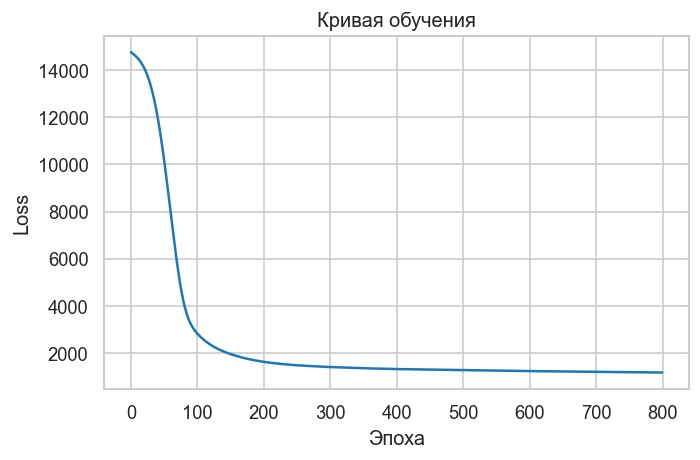

In [18]:
loss_curve = model.named_steps["mlp"].loss_curve_
plt.figure(figsize=(6, 4))
plt.plot(loss_curve, color=PRIMARY_COLOR)
plt.xlabel("Эпоха")
plt.ylabel("Loss")
plt.title("Кривая обучения")
plt.tight_layout()
plt.show()
